In [1]:
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary
import glob
import os
import random

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
from pathlib import Path
image_dir = "../dataset/spectograms/mel_graphic"
labels_path = "../dataset/classes.txt"

In [5]:
image_paths = sorted(glob.glob("../dataset/spectograms/mel_graphic/*.png"))
image_paths[:5]

['../dataset/spectograms/mel_graphic\\001_mel.png',
 '../dataset/spectograms/mel_graphic\\002_mel.png',
 '../dataset/spectograms/mel_graphic\\003_mel.png',
 '../dataset/spectograms/mel_graphic\\004_mel.png',
 '../dataset/spectograms/mel_graphic\\005_mel.png']

In [6]:
image_paths = [os.path.normpath(path) for path in image_paths]
image_paths[:5]

['..\\dataset\\spectograms\\mel_graphic\\001_mel.png',
 '..\\dataset\\spectograms\\mel_graphic\\002_mel.png',
 '..\\dataset\\spectograms\\mel_graphic\\003_mel.png',
 '..\\dataset\\spectograms\\mel_graphic\\004_mel.png',
 '..\\dataset\\spectograms\\mel_graphic\\005_mel.png']

In [7]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from torchvision.models import regnet_y_800mf, RegNet_Y_800MF_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

from PIL import Image
import os

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.RegNet_Y_800MF_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

RegNet_Y_800MF_Weights.IMAGENET1K_V2

In [9]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomGrayscale(p = 0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.image_paths = image_paths

        with open(labels_file, "r") as f:
            lines = f.readlines()
            self.labels = [line.strip() for line in lines]

        self.class_names = sorted(list(set(self.labels)))

        assert len(self.image_paths) == len(self.labels), "Liczba zdjęć ≠ liczba etykiet!"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label_str = self.labels[idx]
        label = self.class_names.index(label_str)  # Zamiana na indeks

        if self.transform:
            image = self.transform(image)

        return image, label


In [11]:
full_dataset = CustomImageDataset(image_dir, labels_path, augmentation_transform)

# Podział 70/20/10
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # dla powtarzalności
)

batch_size=32
# DataLoadery

from torch.utils.data import WeightedRandomSampler, DataLoader


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Setup batch size and number of workers


NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {batch_size} and {NUM_WORKERS} workers.")

Creating DataLoader's with batch size 32 and 8 workers.


In [13]:
classes = full_dataset.class_names
len(classes)

3

In [14]:
len(train_dataset), len(val_dataset), len(test_dataset)

(632, 180, 91)

In [15]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = torchvision.models.regnet_y_800mf(weights=weights).to(device)
for param in model_0.parameters():
    param.requires_grad = False

In [16]:
# Get the length of class_names (one output unit for each class)
output_shape = len(classes)

# Recreate the classifier layer and seed it to the target device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model_0.trunk_output.block4.parameters():
    param.requires_grad = True

for param in model_0.trunk_output.block3.parameters():
    param.requires_grad = True

for param in model_0.trunk_output.block2.parameters():
    param.requires_grad = True

# for param in model_0.trunk_output.block1.parameters():
#     param.requires_grad = True
    
for param in model_0.avgpool.parameters():
    param.requires_grad = True
    
for param in model_0.fc.parameters():
    param.requires_grad = True

model_0.fc = torch.nn.Linear(in_features=784,
                             out_features=output_shape, # same number of output units as our number of classes
                             bias=True).to(device)

In [17]:
# Print a summary using torchinfo (uncomment for actual output)
from torchinfo import summary

summary(model=model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 3]              --                   Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 784, 7, 7]      --                   Partial
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32

In [18]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from timeit import default_timer as timer

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    best_acc = 0
    model_best = torchvision.models.regnet_y_800mf(weights=weights).to(device)

    model_best.fc = torch.nn.Linear(in_features=784,
                                    out_features=output_shape, # same number of output units as our number of classes
                                    bias=True).to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)


        if test_acc >= best_acc:
            best_model = model
            best_acc = test_acc
            torch.save(obj=best_model.state_dict(), f="RegNetTF-best.pth")    


        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"valid_loss: {test_loss:.4f} | "
          f"valid_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
            
    # Return the filled results at the end of the epochs
    return results

In [ ]:
# Define loss and optimizer
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.0001)

In [21]:
# Start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

st_time = timer()
# Setup training and save the results
results = train(model=model_0,
               train_dataloader=train_loader,
               test_dataloader=val_loader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=7,
               device=device)

# End the timer and print out how long it took
e_time = timer()
print(f"[INFO] Total training time: {e_time-st_time:.3f} seconds")

c:\Users\Natalia\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_800MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_800MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_800mf-1b27b58c.pth" to C:\Users\Natalia/.cache\torch\hub\checkpoints\regnet_y_800mf-1b27b58c.pth
100%|██████████| 24.8M/24.8M [00:20<00:00, 1.29MB/s]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0719 | train_acc: 0.4068 | valid_loss: 1.0559 | valid_acc: 0.4438
Epoch: 2 | train_loss: 1.0124 | train_acc: 0.4771 | valid_loss: 0.9743 | valid_acc: 0.4708
Epoch: 3 | train_loss: 0.9237 | train_acc: 0.5302 | valid_loss: 0.9845 | valid_acc: 0.4719
Epoch: 4 | train_loss: 0.8832 | train_acc: 0.5786 | valid_loss: 0.9466 | valid_acc: 0.5312
Epoch: 5 | train_loss: 0.7969 | train_acc: 0.6073 | valid_loss: 0.9600 | valid_acc: 0.4990
Epoch: 6 | train_loss: 0.7774 | train_acc: 0.6104 | valid_loss: 0.9223 | valid_acc: 0.5271
Epoch: 7 | train_loss: 0.7619 | train_acc: 0.6271 | valid_loss: 0.9284 | valid_acc: 0.5198
[INFO] Total training time: 244.072 seconds


In [22]:
MODEL_SAVE_PATH = "RegNetTF-last.pth"

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: RegNetTF-last.pth


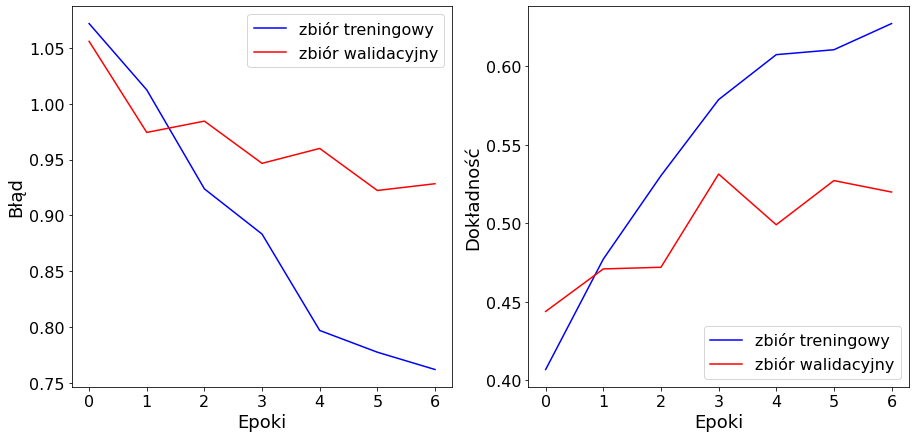

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="zbiór treningowy", color='blue')
    plt.plot(epochs, test_loss, label="zbiór walidacyjny", color='red')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    # plt.yticks(np.arange(0, 0.31, 0.03))
    # plt.xticks(np.arange(0, 20, 2))
    plt.ylabel("Błąd", fontsize=18)
    plt.xlabel("Epoki", fontsize=18)
    plt.legend(loc='upper right', fontsize=16)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="zbiór treningowy", color='blue')
    plt.plot(epochs, test_accuracy, label="zbiór walidacyjny", color='red')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    # plt.yticks(np.arange(0.92, 1.01, 0.01))
    # plt.xticks(np.arange(0, 20, 2))
    plt.ylabel("Dokładność", fontsize=18)
    plt.xlabel("Epoki", fontsize=18)
    plt.legend(loc='lower right', fontsize=16)

plot_loss_curves(results)

In [24]:
model_0.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [25]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

In [26]:
test_acc = check_accuracy(test_loader, model_0)

Got 52 / 91 with accuracy 57.14


In [27]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_loader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1,
        2, 0, 1, 1, 0, 1, 0, 1, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 2,
        1, 2, 2, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 2,
        1, 1, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0])

In [28]:
import torchmetrics, mlxtend

In [29]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_loader])
test_truth

tensor([1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1,
        0, 0, 1, 1, 0, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 1, 2, 2, 2,
        1, 0, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 0, 2, 1, 2, 1, 0, 2,
        0, 1, 2, 1, 1, 2, 0, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 2, 0])

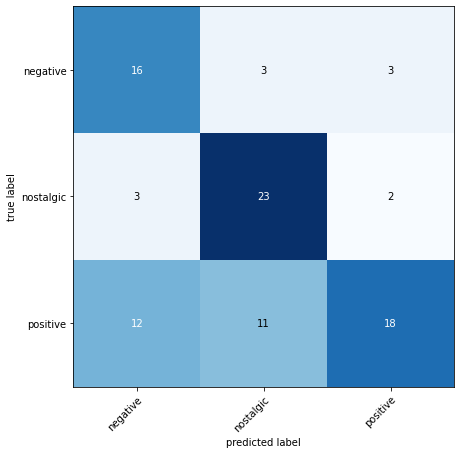

In [30]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classes,
    #class_names=['Flagowy', 'Ósemka', 'Prosty', 'Ratowniczy', 'Refowy', 'Rożkowy', 'Szotowy', 'Wyblinka', 'Zwykły'],
    figsize=(10, 7)
)